<a href="https://colab.research.google.com/github/emely3h/Geospatial_ML/blob/feature%2Funet-experiment-1/notebooks/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training an Unet

This notebook aims to train an Unet to make predictions based on a small subset of the dataset. We will use one original image for training, one for validation and one for testing.


### 1. Loading Data

In [228]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [229]:
! ls
%cd drive/MyDrive/MachineLearning
! ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
ls: cannot open directory '.': Transport endpoint is not connected


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-229-af6b377436d0>", line 2, in <module>
    get_ipython().run_line_magic('cd', 'drive/MyDrive/MachineLearning')
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2314, in run_line_magic
    result = fn(*args, **kwargs)
  File "<decorator-gen-85>", line 2, in cd
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/magics/osm.py", line 334, in cd
    oldcwd = os.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactive

OSError: ignored

In [3]:
#! git clone https://github.com/emely3h/Geospatial_ML
%cd Geospatial_ML
#! git checkout feature/create_mask
! ls


/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning/Geospatial_ML
architecture.drawio  notebooks	   README.md
models		     prepare_data  requirements.txt


In [118]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    concatenate,
    Conv2DTranspose,
    Dropout,
    UpSampling2D
)
from keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import pickle

In [40]:
data_directory = "../data_colab/256_200_17_images"

y_train  = np.load(os.path.join(data_directory, '2022_06_20.npz'))['y_mask']
x_train  = np.load(os.path.join(data_directory, '2022_06_20.npz'))['x_input']

y_val = np.load(os.path.join(data_directory, '2022_06_20.npz'))['y_mask']
x_val = np.load(os.path.join(data_directory, '2022_06_20.npz'))['x_input']

y_test = np.load(os.path.join(data_directory, '2022_06_20.npz'))['y_mask']
x_test = np.load(os.path.join(data_directory, '2022_06_20.npz'))['x_input']

print(y_train.shape)
print(x_train.shape)

print(y_val.shape)
print(x_val.shape)

print(y_test.shape)
print(x_test.shape)

(1251, 256, 256)
(1251, 256, 256, 5)
(1251, 256, 256)
(1251, 256, 256, 5)
(1251, 256, 256)
(1251, 256, 256, 5)


### 2. Diyplay Images

In [41]:
def display_image(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if len(display_list[i].shape) == 3:
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        #plt.axis('off')
    else:
        plt.imshow(display_list[i])
  plt.show()

def display(list_train, list_mask):
  for idx, img_train in enumerate(list_train):
    sample_image, sample_mask = list_train[idx], list_mask[idx]
    sample_image = sample_image[..., :4]
    display_image([sample_image, sample_mask])

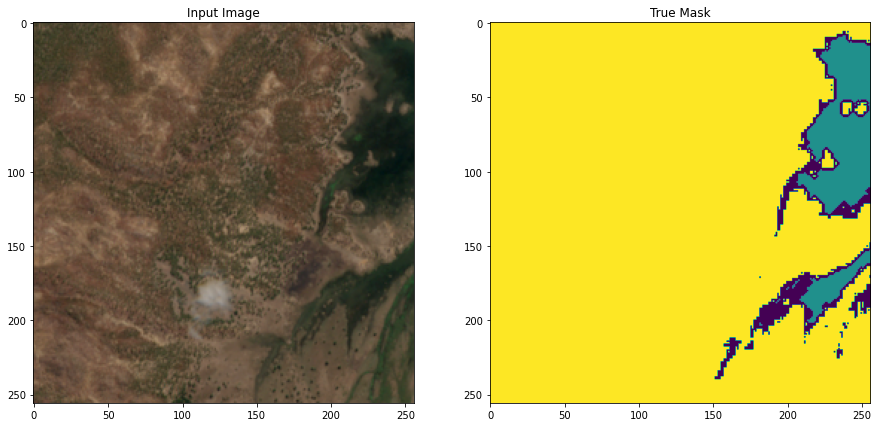

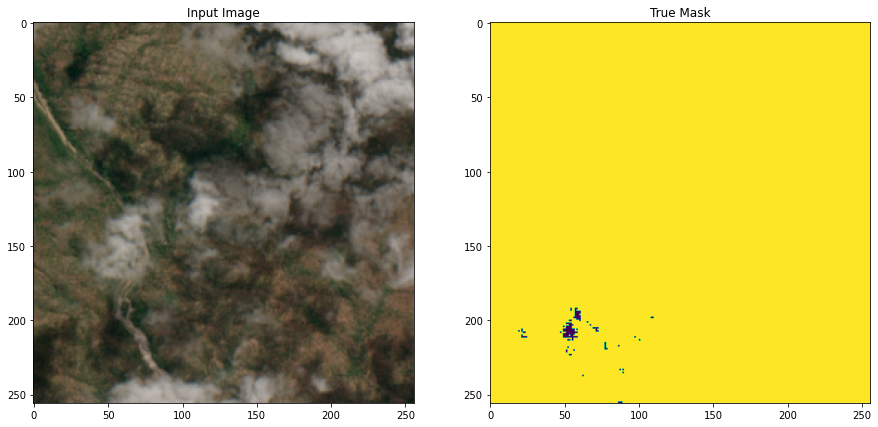

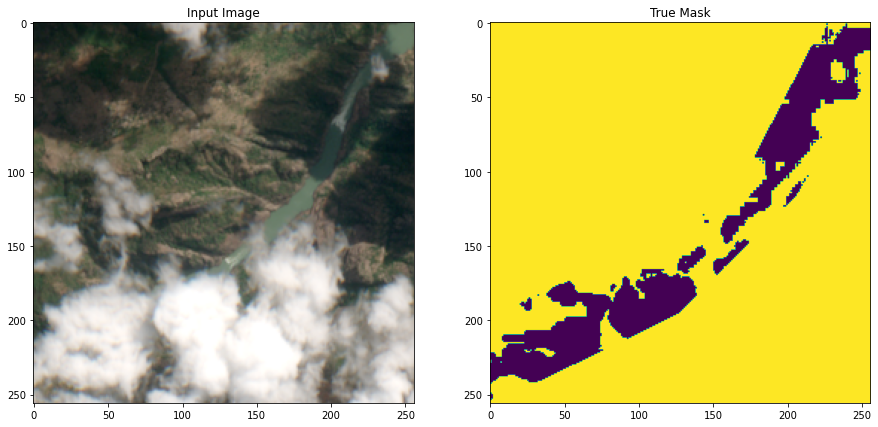

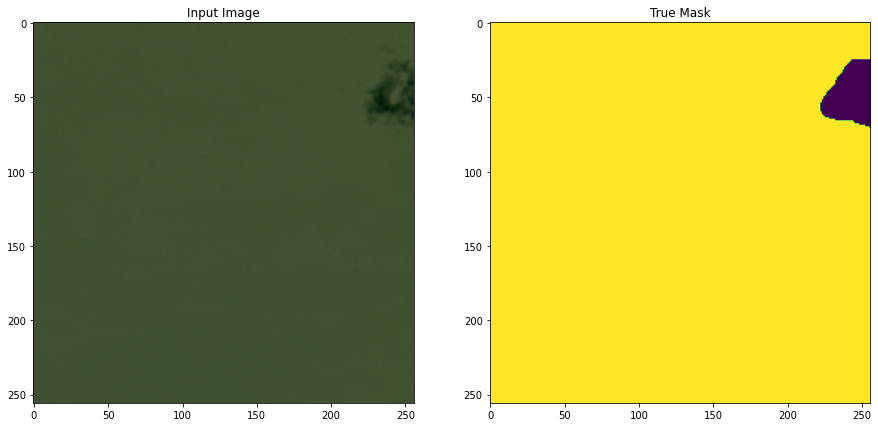

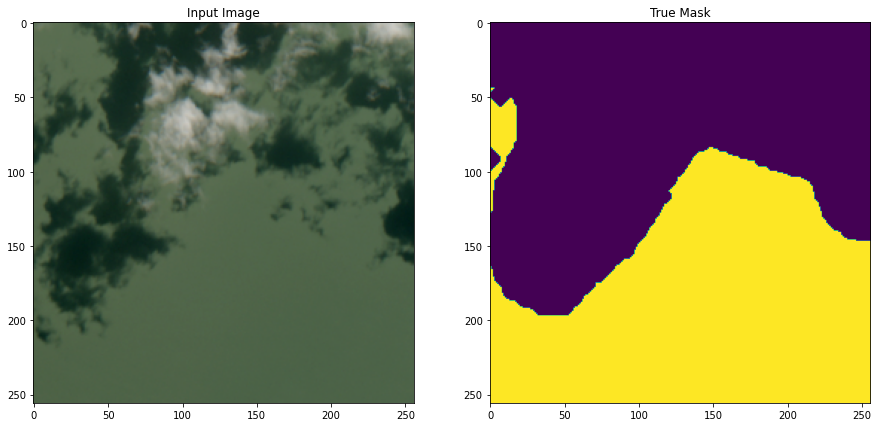

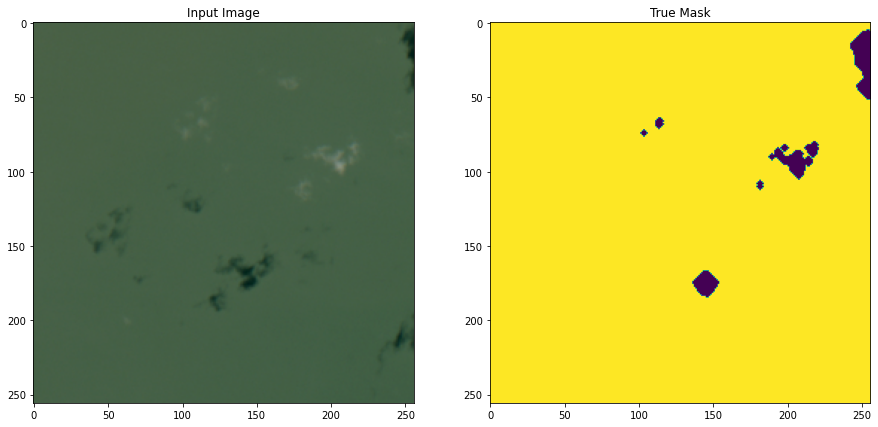

In [42]:
display(x_train[:6], y_train[:6])

### 3. Normalizing + Encoding

In [43]:
def normalizing(X, y):

  print(y.shape)
  y_one_hot =  np.array([tf.one_hot(item, depth=3).numpy() for item in y])
  print(y_one_hot.shape)
  X_normal = X/255
  return X_normal, y_one_hot

In [44]:
x_train, y_train = normalizing(x_train, y_train)

X_val, y_val = normalizing(x_val, y_val)

x_test, y_test = normalizing(x_test, y_test)


(1251, 256, 256)
(1251, 256, 256, 3)
(1251, 256, 256)
(1251, 256, 256, 3)
(1251, 256, 256)
(1251, 256, 256, 3)


### 3. Compiling the model

In [45]:
def unet_2d(input_shape, num_classes):

    # Define the input layer
    inputs = Input(input_shape)

    # Downsample layers
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Upsample layers
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # Output layer
    output = Conv2D(num_classes, (1, 1), activation='softmax')(conv7)

    # Define the model
    model = Model(inputs=[inputs], outputs=[output])

    return model

In [46]:
model = unet_2d(input_shape=(256, 256, 5), num_classes=3)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 256, 256, 64  2944        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_31 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_30[0][0]']              
                                )                                                           

### 4. Training the model

In [63]:
model.compile(optimizer='adam',
              loss=categorical_crossentropy,
              metrics=['accuracy']) # ??? alternatives

early_stop = EarlyStopping(monitor='accuracy', patience=5) ## alternatives for monitor?? val_loss

model_history = model.fit(x=x_train, y=y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[early_stop])



Epoch 1/100
40/40 [==============================] - 17s 314ms/step - loss: 0.0556 - accuracy: 0.9804 - val_loss: 16.1309 - val_accuracy: 0.8917
Epoch 2/100
40/40 [==============================] - 10s 248ms/step - loss: 0.0395 - accuracy: 0.9852 - val_loss: 5.0589 - val_accuracy: 0.9758
Epoch 3/100
40/40 [==============================] - 10s 248ms/step - loss: 0.0394 - accuracy: 0.9851 - val_loss: 5.3192 - val_accuracy: 0.9773
Epoch 4/100
40/40 [==============================] - 10s 248ms/step - loss: 0.0342 - accuracy: 0.9871 - val_loss: 4.3455 - val_accuracy: 0.9862
Epoch 5/100
40/40 [==============================] - 10s 248ms/step - loss: 0.0739 - accuracy: 0.9735 - val_loss: 14.5688 - val_accuracy: 0.9563
Epoch 6/100
40/40 [==============================] - 10s 248ms/step - loss: 0.0421 - accuracy: 0.9839 - val_loss: 5.9291 - val_accuracy: 0.9834
Epoch 7/100
40/40 [==============================] - 10s 250ms/step - loss: 0.0403 - accuracy: 0.9846 - val_loss: 10.7842 - val_accura

### 5. Training Results

In [116]:
def plot_loss_acc(plots, y_scale):
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']
  acc = model_history.history['accuracy']
  val_acc = model_history.history['val_accuracy']

  plt.figure(figsize=(10,6))
  if 'loss' in plots:
    plt.plot(model_history.epoch, loss, 'g', label='Training Loss')
  if 'accuracy' in plots:
    plt.plot(model_history.epoch, acc, 'y', label='Training Accuracy')
  if 'val_loss' in plots:
    plt.plot(model_history.epoch, val_loss, 'r', label='Validation Loss')
  if 'val_accuracy' in plots:
    plt.plot(model_history.epoch, val_acc, 'b', label='Validation Accuracy')
  plt.title('')
  plt.xlabel('Epoch')
  plt.ylabel('Value')
  if y_scale == 'all':
    plt.ylim([0, 1])
  elif y_scale == 'loss':
    plt.ylim([0, 8])
  else:
    plt.ylim([0.8, 1])
  plt.legend()

  plt.show()

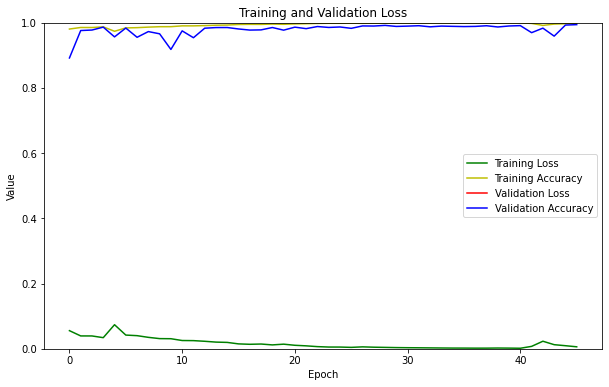

In [104]:
plot_loss_acc(['loss', 'accuracy', 'val_loss', 'val_accuracy'], 'all') ### val_loss not showing

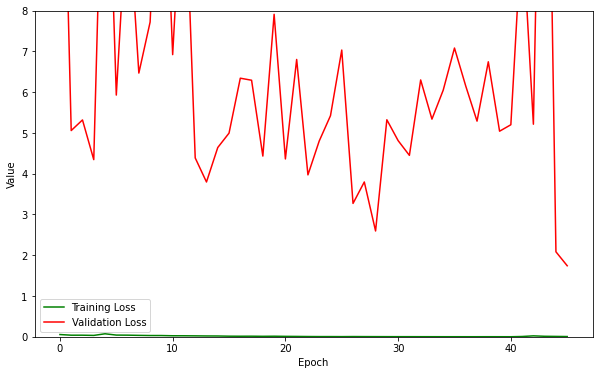

In [117]:
plot_loss_acc(['loss', 'val_loss',], 'loss')

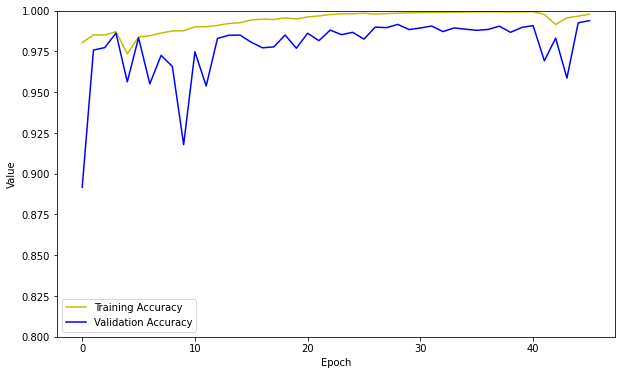

In [110]:
plot_loss_acc(['accuracy', 'val_accuracy'], 'accuracy')

### 6. Saving the model + history

In [226]:
model_name = '256_200_1_train_image_.h5'
model.save(f'../models/{model_name}')

with open('../models/256_200_1_train_image_history.pickle', 'wb') as file_pi:
    pickle.dump(model_history.history, file_pi)

#model = keras.models.load_model(f'../models/{model_name}')

#with open('../models/256_200_1_train_image_history.pickle', "rb") as file_pi:
#    history = pickle.load(file_pi)
#print(history['loss'])


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-226-a1e5648a9417>", line 2, in <module>
    model.save(f'../models/{model_name}')
  File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/lib/io/file_io.py", line 513, in recursive_create_dir_v2
    _pywrap_file_io.RecursivelyCreateDir(compat.path_to_bytes(path))
tensorflow.python.framework.errors_impl.FailedPreconditionError: .. is not a directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError:

FailedPreconditionError: ignored

### 7. Analyzing metrics

In [130]:
predictions = model.predict(x_test)

40/40 [==============================] - 3s 64ms/step


In [222]:
def jacard_coef(y_true, y_pred):

  y_true_f = keras.backend.flatten(y_true) 
  y_pred_f = keras.backend.flatten(y_pred)

  intersection = keras.backend.sum(y_true_f * y_pred_f)
  return (intersection + 1.0) / (
      keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) - intersection + 1.0
  ) ## reason for +1?


def jacard_exact(y_true, y_pred):
  # revert one hot encoding => binary tensor [0, 0, 1] back to label [2] (3D array to 2D array)
  label_map_true = np.argmax(y_true, axis=-1)
  label_map_pred = np.argmax(y_pred, axis=-1)
  # convert 2D array into 1D array
  flatten_true = np.reshape(label_map_true, (-1,))
  flatten_pred = np.reshape(label_map_pred, (-1,))
  # one hot encoding
  one_hot_true = np.eye(3)[flatten_true]
  one_hot_pred = np.eye(3)[flatten_pred]
  # calculate intersection (A geschnitten B)
  intersection = np.sum(one_hot_true * one_hot_pred)
  # calculate union (a u B, A vereint B)
  union = len(one_hot_true) + len(one_hot_pred) - intersection
  # return jacard coefficient
  return (intersection + 1)/(union +1)

def confusion_matrix(y_true, y_pred, label):
  true_positives = 0
  false_positives = 0
  true_negatives = 0
  false_negatives = 0

  # revert one hot encoding => binary tensor [0, 0, 1] back to label [2] (3D array to 2D array)
  label_map_true = np.argmax(y_true, axis=-1)
  label_map_pred = np.argmax(y_pred, axis=-1)
  # convert 2D array into 1D array
  flatten_true = np.reshape(label_map_true, (-1,))
  flatten_pred = np.reshape(label_map_pred, (-1,))

  tp_mask = (flatten_true == flatten_pred) & (flatten_true == label)
  true_positives = np.count_nonzero(tp_mask)

  fn_mask = (flatten_true == label) & (flatten_pred != label)
  false_negatives = np.count_nonzero(fn_mask)

  fp_mask = (flatten_true != label) & (flatten_pred == label)
  false_positives = np.count_nonzero(fp_mask)

  tn_mask = (flatten_true != label) & (flatten_pred != label)
  true_negatives = np.count_nonzero(tn_mask)

    
  return {
      'true_positives': true_positives,
      'false_positives': false_positives,
      'true_negatives': true_negatives,
      'false_negatives': false_negatives
  }


def precision(conf_matrix):
  return conf_matrix['true_positives']/(conf_matrix['true_positives'] + conf_matrix['false_positives'])

def sensitivity_recall(conf_matrix):
  return conf_matrix['true_positives']/(conf_matrix['true_positives'] + conf_matrix['false_negatives'])

def negative_predictive(conf_matrix):
  return conf_matrix['true_negatives']/(conf_matrix['true_negatives'] + conf_matrix['false_negatives'])

def specificy(conf_matrix):
  return conf_matrix['true_negatives']/(conf_matrix['true_negatives'] + conf_matrix['false_positives'])

def f1_scores(conf_matrix):
  prec = precision(conf_matrix)
  recall = sensitivity_recall(conf_matrix)
  return 2 * prec * recall / (prec + recall)


def get_all_metrics(y_true, y_pred):
  jacard = jacard_coef(y_test, predictions)
  
  conf_matrix_land = confusion_matrix(y_test, y_pred, 2)
  conf_matrix_valid = confusion_matrix(y_test, y_pred, 1)
  conf_matrix_invalid = confusion_matrix(y_test, y_pred, 0)

  f1_land = f1_scores(conf_matrix_land)
  f1_invalid = f1_scores(conf_matrix_invalid)
  f1_valid = f1_scores(conf_matrix_valid)
  return {
      'jacard': jacard,
      'conf_matrix_land': conf_matrix_land,
      'conf_matrix_valid': conf_matrix_valid,
      'conf_matrix_invalid': conf_matrix_invalid,
      'f1_land': f1_land,
      'f1_invalid': f1_invalid,
      'f1_valid': f1_valid
  }
  #todo add pixel accuracy


In [224]:
# todo: sanity check => does sum add up to all pixels?
metrics = get_all_metrics(y_test, predictions)
print(metrics)
metrics['training_data'] = 

with open('../models/256_200_1_train_metrics.pickle', 'wb') as file_pi:
    pickle.dump(metrics, file_pi)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



{'jacard': <tf.Tensor: shape=(), dtype=float32, numpy=0.99576277>, 'conf_matrix_land': {'true_positives': 38409695, 'false_positives': 36504, 'true_negatives': 43529156, 'false_negatives': 10181}, 'conf_matrix_valid': {'true_positives': 34649009, 'false_positives': 39185, 'true_negatives': 47272019, 'false_negatives': 25323}, 'conf_matrix_invalid': {'true_positives': 8816876, 'false_positives': 34267, 'true_negatives': 73059941, 'false_negatives': 74452}, 'f1_land': 0.9993926449347128, 'f1_invalid': 0.9938723867718312, 'f1_valid': 0.9990699877337224}
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-224-bbb138750d35>", line 5, in <module>
    with open('../models/256_200_1_train_metrics.pickle', 'wb') as file_pi:
OSError: [Errno 107] Transport endpoint is not connected: '../models/256_200_1_train_metrics.pickle'

During h

OSError: ignored

### 8. Making predictions

In [230]:
display([x_test[5], y_test[5], predictions[5]])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-230-2404c0535c1c>", line 4, in <module>
    display([x_test[5], y_train[5], predictions[5]])
TypeError: display() missing 1 required positional argument: 'list_mask'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/us

TypeError: ignored

### 8. Summary

metrics
which pictures have been used => how many tiles did they have
how long did training take

- possible to get best predicted tile and worst predicted tile
- check how many pixels each class